In [28]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from models.utils import plot_learning_curve

In [3]:
csv_path = "/home/ryan.zurrin001/Projects/omama/_EXPERIMENTS/CS438/labels/features_balanced_scaled_mulitplicative.csv"

In [4]:
features = pd.read_csv(csv_path)

In [5]:
features = features.drop(columns=['label', 'score', 'coords1', 'coords2', 'coords3', 'coords4'])

In [5]:
# features = features.drop(columns=['label', 'score', 'coords1', 'coords2', 'coords3', 'coords4',
#        'resized_coords1', 'resized_coords2', 'resized_coords3',
#        'resized_coords4'])

In [6]:
# Separate the features and target label
X = features.drop('target_label', axis=1)
y = features['target_label']

In [7]:
len(X)

33064

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
from sklearn.neural_network import MLPClassifier

In [10]:
# Initialize alternative models
neural_net = MLPClassifier(max_iter=2000)

# Fit alternative models
# Note: These models have their own hyperparameters that you can tune
neural_net.fit(X_train, y_train)


MLPClassifier(max_iter=2000)

In [17]:
from sklearn.metrics import classification_report

# Predict on the validation set
y_val_pred_nn = neural_net.predict(X_val)
print(classification_report(y_val, y_val_pred_nn))

              precision    recall  f1-score   support

           0       0.65      0.57      0.61      2424
           1       0.63      0.70      0.66      2536

    accuracy                           0.64      4960
   macro avg       0.64      0.64      0.64      4960
weighted avg       0.64      0.64      0.64      4960



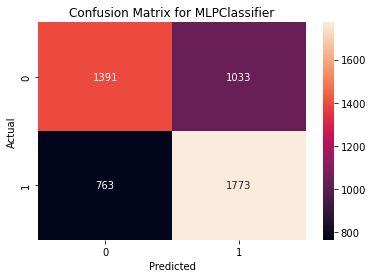

In [18]:
from sklearn.metrics import confusion_matrix

cm_nn = confusion_matrix(y_val, y_val_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLPClassifier')
plt.show()

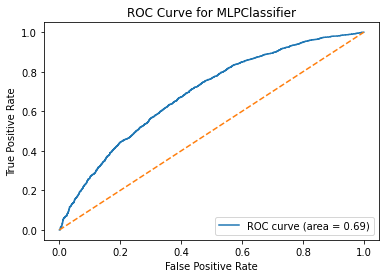

In [19]:
from sklearn.metrics import roc_curve, auc

# This assumes your neural_net model has a method `predict_proba`
y_probs_nn = neural_net.predict_proba(X_val)[:, 1]
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_val, y_probs_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.plot(fpr_nn, tpr_nn, label=f'ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLPClassifier')
plt.legend(loc='lower right')
plt.show()

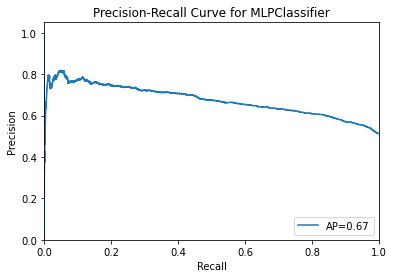

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

average_precision_nn = average_precision_score(y_val, y_probs_nn)
precision_nn, recall_nn, _ = precision_recall_curve(y_val, y_probs_nn)

plt.step(recall_nn, precision_nn, where='post', label=f'AP={average_precision_nn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for MLPClassifier')
plt.legend(loc='lower right')
plt.show()

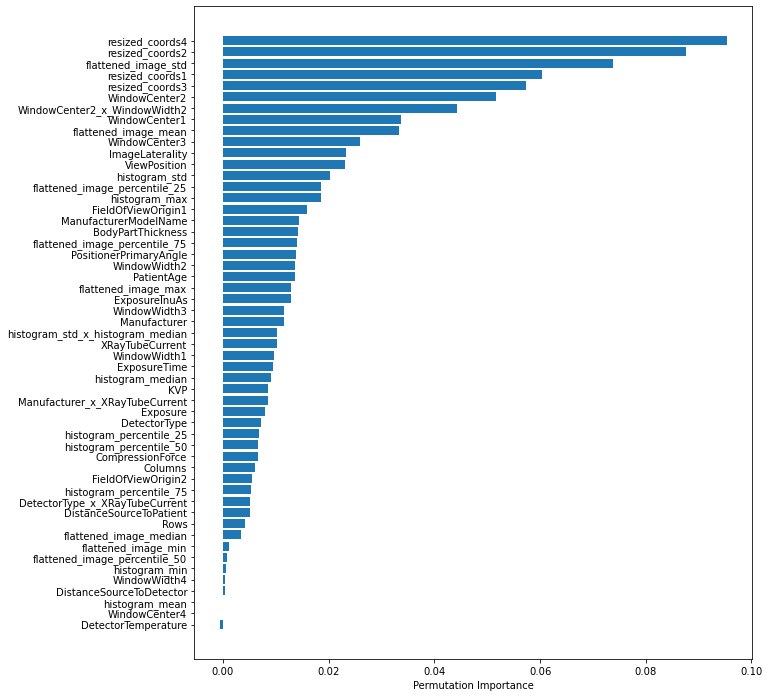

In [15]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(neural_net, X_val, y_val, n_repeats=10, random_state=0, n_jobs=-1)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10,12))

plt.barh(range(X_train.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

In [30]:
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [31]:
plot_learning_curve(neural_net, X_train, y_train, np.linspace(0.1, 1.0, 15), 5, scorer)

TypeError: argument of type '_ProbaScorer' is not iterable

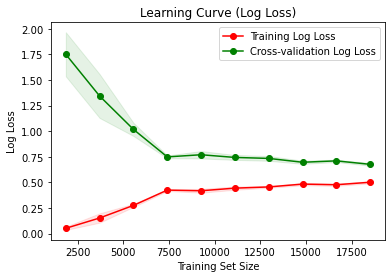

In [27]:
# Assuming neural_net is your MLPClassifier model

# Create a scorer from the log_loss function
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

train_sizes, train_scores, validation_scores = learning_curve(
    neural_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring=log_loss_scorer, n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)  # Note the negative sign
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = -np.mean(validation_scores, axis=1)  # Note the negative sign
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Log Loss")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation Log Loss")

plt.title("Learning Curve (Log Loss)")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.show()

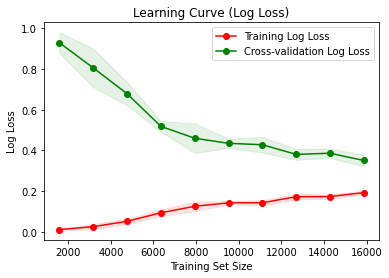

In [16]:


# Assuming neural_net is your MLPClassifier model

# Create a scorer from the log_loss function
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

train_sizes, train_scores, validation_scores = learning_curve(
    neural_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring=log_loss_scorer, n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)  # Note the negative sign
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = -np.mean(validation_scores, axis=1)  # Note the negative sign
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Log Loss")
plt.plot(train_sizes, validation_mean, 'o-', color="g", label="Cross-validation Log Loss")

plt.title("Learning Curve (Log Loss)")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.legend(loc="best")
plt.show()